In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2
import h5py

from pathlib import Path
from sglm.models import sglm_cv
import itertools
import time
import glob
import numpy as np
import pandas as pd
import numpy as np
from sglm.features import gen_signal_df as gsd
from sglm.features import build_features as bf
from sglm.features import setup_model_fit as smf
from sglm.models import sglm_cv
from sglm import models
from sglm.visualization import visualize
from sglm.models import train_model
from sglm.models import eval
from sglm import features
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import json

import traceback
import warnings
import sys

In [2]:
# From stack overflow
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [3]:
def extract_multifiles(wt_used, signal_files, widest_orders, shift_spacer='_sft_'):
    # needed info
    # Params: wt_used, signal_files, widest_orders, multifile_fit
    # Returns: mouse_names, combo_dfs, combo_fns, X_cols_sftd

    file_ids = [Path(_).parts[-1] for _ in signal_files]
    print('file_ids', file_ids)
    combo_dfs, X_cols_sftd, _ = smf.multi_file_analysis_prep(signal_files, widest_orders, file_ids, shift_spacer='_sft_', keep_unshifted=True)
#     combo_dfs, X_cols_sftd, _ = smf.multi_file_analysis_prep_nosft(signal_files, widest_orders, file_ids)
    combo_fns = ['_'.join(wt_used).replace('WT', '').replace('S', '')]
    mouse_names = combo_fns

    return mouse_names, combo_dfs, combo_fns, X_cols_sftd

In [4]:
def dump_dict_to_json(source_dict, json_path):
    with open(str((json_path).resolve()), 'w') as json_file:
        json.dump(source_dict, json_file)

def read_json(json_path):
    with open(str((json_path).resolve()), 'r') as json_file:
        read_json = json.load(json_file)
    return read_json

In [5]:
def id_rows_with_all_cols(dfrel_basis,
                          X_y_pairings,
                          X_cols_sftd, 
                          drop_cols_basis = ['nTrial', 'nTrial_filenum',
                                             'cpn', 'cpx', 'spnnr', 'spxnr', 'spnr', 'spxr',
                                             
                                             'photometryCenterInIndex', 'photometryCenterOutIndex',
                                             'photometrySideInIndexr', 'photometrySideInIndexnr',
                                             'photometrySideOutIndex', 'spnnrOff',
                                             
                                             'photometrySideInIndexAA', 'photometrySideInIndexAa',
                                             'photometrySideInIndexaA', 'photometrySideInIndexaa',
                                             'photometrySideInIndexAB', 'photometrySideInIndexAb',
                                             'photometrySideInIndexaB', 'photometrySideInIndexab',
#                                              'sl',
#                                              'slOff'
                                            ]):
    full_drop_basis = []
    y_col_lst = []
    for X_y_dct in X_y_pairings:
        full_drop_basis += bf.col_shift_bounds_dict_to_col_list(X_y_dct['X_cols'], X_cols_sftd)
        y_col_lst += [X_y_dct['y_col']]
    y_col_drop_basis = sorted(list(set(y_col_lst)))
    full_drop_basis = sorted(list(set(drop_cols_basis + full_drop_basis + y_col_drop_basis)))

    num_cols_na = (dfrel_basis[full_drop_basis].isna().sum(axis=1))
    num_y_0 = (dfrel_basis[y_col_drop_basis] == 0).sum(axis=1)
    has_all_cols = (num_cols_na == 0)&(num_y_0 == 0)

    return has_all_cols

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

In [6]:
def get_holdout_and_cv_idx(df_available, pholdout, folds, pgss, filter_series, id_cols=['nTrial_filenum']):
    holdout_series = models.split_data.holdout_split_by_trial_id(df_available,
                                                                id_cols=id_cols,
                                                                perc_holdout=pholdout)
    cv_idx_lst = models.split_data.cv_idx_by_trial_id(dfrel_basis_has_all_cols[(~holdout_series)&(filter_series)],
                                                             trial_id_columns=id_cols,
                                                             num_folds=folds,
                                                             test_size=pgss)
    return holdout_series, cv_idx_lst

In [7]:
### Part 1
param_set_json_name = 'full_model_param_set.json'

# source_data_path = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\data\interim')
# output_path = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs_clean')

# source_data_path = Path(r'/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/data/interim')
# output_path = Path(r'/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/outputs_clean')

source_data_path = Path(r'/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/data/mike-GLM_8020-interim')
output_path = Path(r'/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/outputs-mike-GLM_8020')

preproc_params_name = r'preproc_params.json'
basis_name = r'_basis.csv'
figname = 'fig_8020'
groupid = 'g1'
param_set_id = '-20_+20'


In [8]:
param_set_output_path = output_path / Path(figname) / Path(groupid) / Path(param_set_id)
param_set_dct = read_json(param_set_output_path / param_set_json_name)

source_data_path = Path(param_set_dct['source_data_path'])
output_path = Path(param_set_dct['output_path'])
basis_name = param_set_dct['basis_name']
figname = param_set_dct['figname']
groupid = param_set_dct['groupid']
param_set_id = param_set_dct['param_set_id']
neg_order = param_set_dct['neg_order']
pos_order = param_set_dct['pos_order']
fix_training = param_set_dct['fix_training']
num_runs = param_set_dct['num_runs']
folds = param_set_dct['folds']
pholdout = param_set_dct['pholdout']
pgss = param_set_dct['pgss']
score_method = param_set_dct['score_method']
val_test_inx_sel_method = param_set_dct['val_test_inx_sel_method']
X_y_pairings_lst = param_set_dct['X_y_pairings_lst']
kwargs_iterations = param_set_dct['kwargs_iterations']
kwargs_fixed = param_set_dct['kwargs_fixed']
dfrr_cols = param_set_dct['dfrr_cols']
count_event_names = param_set_dct['count_event_names']

glm_kwarg_lst = sglm_cv.generate_mult_params(kwargs_iterations, kwargs_fixed)

In [9]:
### Part 1
data_path = (source_data_path / figname / groupid)

interim_preproc_errors_path = data_path / 'interim_preproc_errors.csv'
interim_preproc_errors_df = pd.read_csv(str(interim_preproc_errors_path.resolve()))
error_file_list = interim_preproc_errors_df['out_file_errors'].to_list()

preproc_params = read_json(source_data_path / preproc_params_name)
dump_dict_to_json(preproc_params, param_set_output_path / preproc_params_name)



basis = pd.read_csv(source_data_path / basis_name, index_col=0)
basis['mouseid'] = basis['mouseid'].astype(str)
relevant_basis = basis[(basis['figname'] == figname)&(basis['groupid'] == groupid)]
wt_used = basis['mouseid'].tolist()

In [10]:
# Load Signal Data
signal_files = []
mouse_names = []
for inx, basis_row in basis.iterrows():
    signal_file_out = basis_row['signal_file_out']
    
    if signal_file_out in error_file_list:
        print(f'Preprocessing error found for file: {signal_file_out}')
        continue
    
    signal_path = data_path / signal_file_out
    signal_files.append(str(signal_path.resolve()))
    mouse_names.append(basis_row['mouseid'])

Preprocessing error found for file: GLM_SIGNALS_INTERIM_sstflp26_03232021.txt
Preprocessing error found for file: GLM_SIGNALS_INTERIM_sstflp15_07242019.txt


In [11]:
# # Part 2: Generate base files to use by all runs and create folders for each run

# max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
# multi_start = time.time()
# for iXyp, X_y_pairings in enumerate(X_y_pairings_lst):

#     widest_orders = smf.xy_pairs_to_widest_orders([{'X_cols': smf.X_cols_dict_to_default(_['X_cols'], neg_order, pos_order),
#                                                     'y_col': _['y_col']} for _ in X_y_pairings])
#     max_cols_len = max_cols_len_lst[iXyp]
# #     mouse_names, combo_dfs, combo_fns, X_cols_sftd = extract_multifiles(wt_used, signal_files, widest_orders)
    
#     file_ids = [Path(_).parts[-1] for _ in signal_files]
#     signal_df, signal_df_unsft = smf.multi_file_analysis_prep(signal_files, widest_orders, file_ids)
#     combo_fns = ['_'.join(wt_used).replace('WT', '').replace('S', '')]
#     mouse_names = combo_fns
    
#     break

# whr = np.where(signal_df.fillna(-1) != signal_df_unsft.fillna(-1))
# signal_df.iloc[whr[0][:10],whr[1][:10]]

# signal_df_unsft.iloc[whr[0][:10],whr[1][:10]]
# break

In [12]:
# plot_width = 2
# plot_rows_lst = [_//plot_width + (_%plot_width > 0)*1 for _ in max_cols_len_lst]

In [13]:
# # Part 2: Generate base files to use by all runs and create folders for each run

# max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
# for iXyp, X_y_pairings in enumerate(X_y_pairings_lst):
    
#     Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
#     Xyp_path.mkdir(parents=True, exist_ok=False)
#     dump_dict_to_json(X_y_pairings, Xyp_path / Path('X_y_pairings.json'))
    
    
#     widest_orders = smf.xy_pairs_to_widest_orders([{'X_cols': smf.X_cols_dict_to_default(_['X_cols'], neg_order, pos_order),
#                                                     'y_col': _['y_col']} for _ in X_y_pairings])
#     max_cols_len = max_cols_len_lst[iXyp]
#     mouse_names, combo_dfs, combo_fns, X_cols_sftd = extract_multifiles(wt_used, signal_files, widest_orders, shift_spacer='_sft_')
    
#     start = time.time()
#     results_dict = {}
    
#     dfrel_basis = combo_dfs[0].reset_index(drop=False).copy()
    
# #     fn = Path(combo_fns[file_num].split('.')[0]).parts[-1]
    
#     mouse_id = mouse_names[0]
#     dfresids_cols = np.copy(dfrr_cols).tolist()
# #     run_id = f'{fn}_{iXyp}'         
#     has_all_cols = id_rows_with_all_cols(dfrel_basis, X_y_pairings, X_cols_sftd)
#     if has_all_cols.sum() == 0:
#         print(f'No datapoints found for non-NaN dropcols & non-zero ycols for fixed_training: {prefix}_{fn}')
#         continue

#     dfrel_basis['has_all_cols'] = has_all_cols    
#     basis_column_indices = {
#         'basis_cols': list(dfrel_basis.columns),
#         'basis_index': list(dfrel_basis.index),
#     }
#     dump_dict_to_json(basis_column_indices, Xyp_path / Path('basis_column_indices.json'))
    
    
# #     dfrel_basis[dfresids_cols].set_index(['nTrial_filenum'], append=True).to_hdf(str((Xyp_path / Path(f'combo_df.h5')).resolve()), key='combo', index=True,)
# #     dfrel_basis[dfresids_cols].set_index(['nTrial_filenum'], append=True).to_csv(str((Xyp_path / Path(f'combo_df.csv')).resolve()), index=True)
#     dfrel_basis[[_ for _ in dfrel_basis.columns if '_sft_' not in _]].to_csv(str((Xyp_path / Path(f'combo_df.csv')).resolve()), index=True)
# #     dfrel_basis.to_hdf(str((Xyp_path / Path(f'combo_df.hd5')).resolve()), key='holdout', index=True)
    
# #     dfrel_basis_reload = pd.read_csv(str((Xyp_path / Path(f'combo_df.csv')).resolve()), index_col=0)
# #     dfrel_basis_reload, X_cols_sftd_reload = smf.timeshift_vals_by_dict(dfrel_basis_reload, widest_orders, keep_nans=True,
# #                                                                         groupby_cols=['file_num'], shift_spacer='_sft_')
    
#     dfrel_basis_has_all_cols = dfrel_basis[dfrel_basis['has_all_cols']]
#     cv_holdout_idx_params = dict(df_available=dfrel_basis_has_all_cols,
#                                  pholdout=pholdout,
#                                  folds=folds,
#                                  pgss=pgss,
#                                  filter_series=dfrel_basis_has_all_cols['wi_trial_keep'],
#                                  id_cols=['nTrial_filenum'])
    
#     for irun in range(num_runs):
#         holdout_irun, cv_idx_irun = get_holdout_and_cv_idx(**cv_holdout_idx_params)
        
#         for iXyd, X_y_dct in enumerate(X_y_pairings):
#             holdout_iXyd, cv_idx_iXyd = get_holdout_and_cv_idx(**cv_holdout_idx_params)
            
#             for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):
#                 holdout_igkwargs, cv_idx_igkwargs = get_holdout_and_cv_idx(**cv_holdout_idx_params)
                
#                 run_path = Xyp_path / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}') / Path(f'irun_{irun}')
#                 run_path.mkdir(parents=True, exist_ok=False)
                
#                 specific_model_params = {
#                     'mouse_id': mouse_id,
#                     'irun': irun,
#                     'iXyd': iXyd,
#                     'igkwargs': igkwargs,
#                     'X_y_dct': X_y_dct,
#                     'X_cols': bf.col_shift_bounds_dict_to_col_list(X_y_dct['X_cols'], X_cols_sftd, shift_spacer='_sft_'),
#                     'y_col': X_y_dct['y_col'],
#                     'name': X_y_dct['name'],
#                     'glm_kwargs': glm_kwargs,
#                 }
                
#                 dump_dict_to_json(specific_model_params, run_path / Path('specific_model_params.json'))
#                 dump_dict_to_json(param_set_dct, run_path / param_set_json_name)
                
#                 holdout_options_df = pd.DataFrame({'holdout_irun': holdout_irun,
#                                            'holdout_iXyd':holdout_iXyd,
#                                            'holdout_igkwargs':holdout_igkwargs},
#                                           index=dfrel_basis_has_all_cols.index)
                
# #                 holdout_df.to_hdf(str((run_path / 'holdout_options.hd5').resolve()), key='holdout')
                
#                 cv_options_dct = {
#                     'cv_idx_irun':cv_idx_irun,
#                     'cv_idx_iXyd':cv_idx_iXyd,
#                     'cv_idx_igkwargs':cv_idx_igkwargs,
#                 }
# #                 np.save(str((run_path/'cv_options.npy').resolve()), np.array(cv_options_dct, dtype='object'))
                
#                 kfold_cv_idx = cv_options_dct[f'cv_idx_{val_test_inx_sel_method}']
#                 holdout_srs = holdout_options_df[f'holdout_{val_test_inx_sel_method}']
                
#                 np.save(str((run_path/'kfold_cv_idx.npy').resolve()), np.array(kfold_cv_idx, dtype='object'))
                
# #                 holdout_srs.to_hdf(str((run_path / 'holdout.hd5').resolve()), key='holdout')
#                 holdout_srs.to_csv(str((run_path / 'holdout.csv').resolve()), index=True)
                
                
                
#                 ####################################################################################
#                 ####################################################################################
#                 ####################################################################################
#                 ####################################################################################
#                 ####################################################################################
#                 #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
#                 #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
#                 #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
#                 #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
#                 #### JZ TODO: MOVE TO SEPARATE FILE FOR PARALLELIZATION OVER DEEPEST FOLDERS... ####
#                 ####################################################################################
#                 ####################################################################################
#                 ####################################################################################
#                 ####################################################################################
#                 ####################################################################################
                

In [14]:
# [_ for _ in glob.glob('/Users/josh/Documents/github_repos/sabatinilab-glm/sglm/data/mike-GLM_8020-interim/fig_8020/g1/*') if '03232021' in _]

In [15]:

# max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
# for iXyp, _ in enumerate(X_y_pairings_lst):
#     for irun in range(num_runs):
#         for iXyd, X_y_dct in enumerate(X_y_pairings):
#             for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):
#                 run_start = time.time()
                
#                 Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
#                 X_y_pairings = read_json(Xyp_path / Path('X_y_pairings.json'))
#                 widest_orders = smf.xy_pairs_to_widest_orders([{'X_cols': smf.X_cols_dict_to_default(_['X_cols'], neg_order, pos_order),
#                                                                 'y_col': _['y_col']} for _ in X_y_pairings])
#                 max_cols_len = max_cols_len_lst[iXyp]
                
#                 run_path = Xyp_path / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}') / Path(f'irun_{irun}')
#                 specific_model_params = read_json(run_path / Path('specific_model_params.json'))
#                 param_set_dct = read_json(run_path / param_set_json_name)
                
#                 X_cols = specific_model_params['X_cols']
#                 y_col = specific_model_params['y_col']
#                 name = specific_model_params['name']
                
#                 kfold_cv_idx = np.load(str((run_path / 'kfold_cv_idx.npy').resolve()), allow_pickle=True)
#                 holdout_srs = pd.read_csv(str((run_path / 'holdout.csv').resolve()), index_col=0).iloc[:,0]
                
#                 basis_column_indices = read_json(Xyp_path / Path('basis_column_indices.json'))
# #                 print(f'basis_column_indices: index: {len(basis_column_indices["basis_index"])}, columns: {len(basis_column_indices["basis_cols"])}')
#                 dfrel_basis_load = pd.read_csv(str((Xyp_path / Path(f'combo_df.csv')).resolve()))
# #                 print('A: dfrel_basis_load.shape',dfrel_basis_load.shape)



#                 dfrel_basis_load, X_cols_sftd_load = smf.timeshift_vals_by_dict(dfrel_basis_load, widest_orders, keep_nans=True, groupby_cols=['file_num'], shift_spacer='_sft_',)
# #                 print('B: dfrel_basis_load.shape',dfrel_basis_load.shape)
                
#                 X_cols_sftd_load = [_ for _ in basis_column_indices if _ in X_cols_sftd_load]
#                 dfrel_basis = dfrel_basis_load.loc[basis_column_indices['basis_index'], basis_column_indices['basis_cols']]
#                 dfrel_basis = dfrel_basis.copy()
                
# #                 print('X_cols', X_cols)
# #                 print('X_cols_sftd_load', X_cols_sftd_load)
                
#                 dfrel_basis['holdout'] = holdout_srs
#                 dfrel_basis_has_all_cols = dfrel_basis[dfrel_basis['has_all_cols']]
                
#                 df_train = dfrel_basis_has_all_cols[(~holdout_srs)&(dfrel_basis_has_all_cols['wi_trial_keep'])]
#                 df_holdout = dfrel_basis_has_all_cols[(holdout_srs)&(dfrel_basis_has_all_cols['wi_trial_keep'])]
#                 X_train, y_train, X_holdout, y_holdout = df_train[X_cols], df_train[y_col], df_holdout[X_cols], df_holdout[y_col]
                
# #                 print('Pre-CV:', df_train.shape, '|', X_train.shape, y_train.shape, X_holdout.shape, y_holdout.shape)
#                 best_score, best_score_std, best_params, best_model, cv_results = models.sglm_cv.simple_cv_fit(X_train, y_train, kfold_cv_idx, [glm_kwargs], model_type='Normal',
#                                                                                                             verbose=0, score_method=score_method)
# #                 print('Pre-Fit:', df_train.shape, '|', X_train.shape, y_train.shape, X_holdout.shape, y_holdout.shape)
#                 glm, holdout_score, holdout_neg_mse_score = eval.training_fit_holdout_score(X_train, y_train, X_holdout, y_holdout, glm_kwargs)
                
#                 run_end = time.time()
                
#                 event_counts_train = {count_event_names[key]: df_train[key].sum() for key in count_event_names}
#                 event_counts_holdout = {count_event_names[key]: df_holdout[key].sum() for key in count_event_names}
                
#                 fitted_glm = {
#                     'model': {
#                         'intercept_': glm.intercept_,
#                         'coef_': list(glm.coef_),
#                         'X_names_': X_cols,
#                         'y_name_': y_col,
#                     },
#                     'score': {
#                         'mse_tr': -glm.neg_mse_score(X_train, y_train),
#                         'mse_cv': cv_results['full_cv_results'][0]['cv_mse_score'],
#                         'mse_te': -glm.neg_mse_score(X_holdout, y_holdout),
                        
#                         'r2_tr': glm.r2_score(X_train, y_train),
#                         'r2_cv': cv_results['full_cv_results'][0]['cv_R2_score'],
#                         'r2_te': glm.r2_score(X_holdout, y_holdout),
#                     },
#                     'fit_details': {
#                         'time_passed': str(run_end - run_start) + ' s',
#                         'train_event_counts': event_counts_train,
#                         'holdout_event_counts': event_counts_holdout,
#                     },
#                 }
#                 dump_dict_to_json(fitted_glm, run_path / 'fitted_glm.json')
                
#                 assert len(cv_results['full_cv_results']) == 1
#                 assert holdout_neg_mse_score == glm.neg_mse_score(X_holdout, y_holdout)
                
#                 dfrel_basis['pred_'+y_col] = pd.Series(glm.predict(dfrel_basis_has_all_cols[X_cols]), index=dfrel_basis_has_all_cols.index)
#                 nonnan_X = (dfrel_basis[X_cols].isna().sum(axis=1) == 0)
#                 dfrel_basis['predALL_'+y_col] = pd.Series(glm.predict(dfrel_basis[X_cols][nonnan_X]), index=dfrel_basis.index[nonnan_X])
#                 dfrel_basis[dfresids_cols + ['holdout', y_col, 'pred_'+y_col, 'predALL_'+y_col]].to_csv(str((run_path / 'preds.csv').resolve()))
                
#                 print('======')

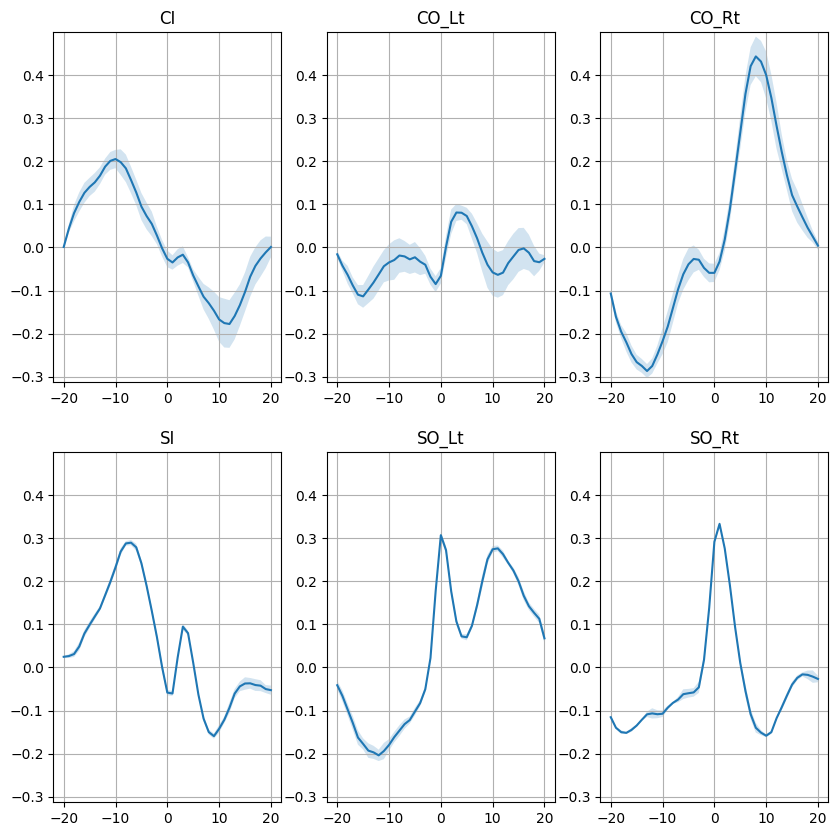

In [16]:

max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
for iXyp, X_y_pairings in enumerate(X_y_pairings_lst):
    for iXyd, X_y_dct in enumerate(X_y_pairings):
        for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):
            agg_coefs_lst = []
            for irun in range(num_runs):
                run_start = time.time()
                
                Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
                run_path = Xyp_path / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}') / Path(f'irun_{irun}')
                fitted_glm = read_json(run_path / 'fitted_glm.json')
                
                coefs = pd.DataFrame(list(zip(fitted_glm['model']['X_names_'], fitted_glm['model']['coef_'])), columns=['name', 'coef'])
                coefs['name_lst'] = coefs['name'].str.split('_sft_')
                coefs['col'] = coefs['name_lst'].apply(lambda x: x[0])
                coefs['sft'] = coefs['name_lst'].apply(lambda x: x[1]).astype('int')
                
                agg_coefs_lst.append(coefs)
            
            agg_coefs = pd.concat(agg_coefs_lst)

            gb_coefs = agg_coefs.groupby(['col', 'sft'])['coef'].agg([np.mean, np.std, np.size])
            gb_coefs['lb'] = gb_coefs['mean'] - gb_coefs['std']/np.sqrt(gb_coefs['size'])*1.96
            gb_coefs['ub'] = gb_coefs['mean'] + gb_coefs['std']/np.sqrt(gb_coefs['size'])*1.96

            gb_coefs = gb_coefs.reset_index()
            fig,axes = plt.subplots(gb_coefs['col'].nunique()//3,3,figsize=(10,10))

            min_y = gb_coefs['lb'].min()-0.01
            max_y = gb_coefs['ub'].max()+0.01
            i = 0
            for gc, gc_df in gb_coefs.groupby('col'):
                axes[i//3,i%3].set_title(gc.replace('Index','').replace('photometry','').replace('enter','').replace('ut','_').replace('ide','').replace('In','I'))
                axes[i//3,i%3].plot(gc_df['sft'], gc_df['mean'])
                axes[i//3,i%3].fill_between(gc_df['sft'], gc_df['lb'], gc_df['ub'], alpha=0.2)
                axes[i//3,i%3].grid(True)
                i += 1

            i = 0
            for gc, gc_df in gb_coefs.groupby('col'):
                axes[i//3,i%3].set_ylim((min_y, max_y))
                i += 1

46.69228196144104


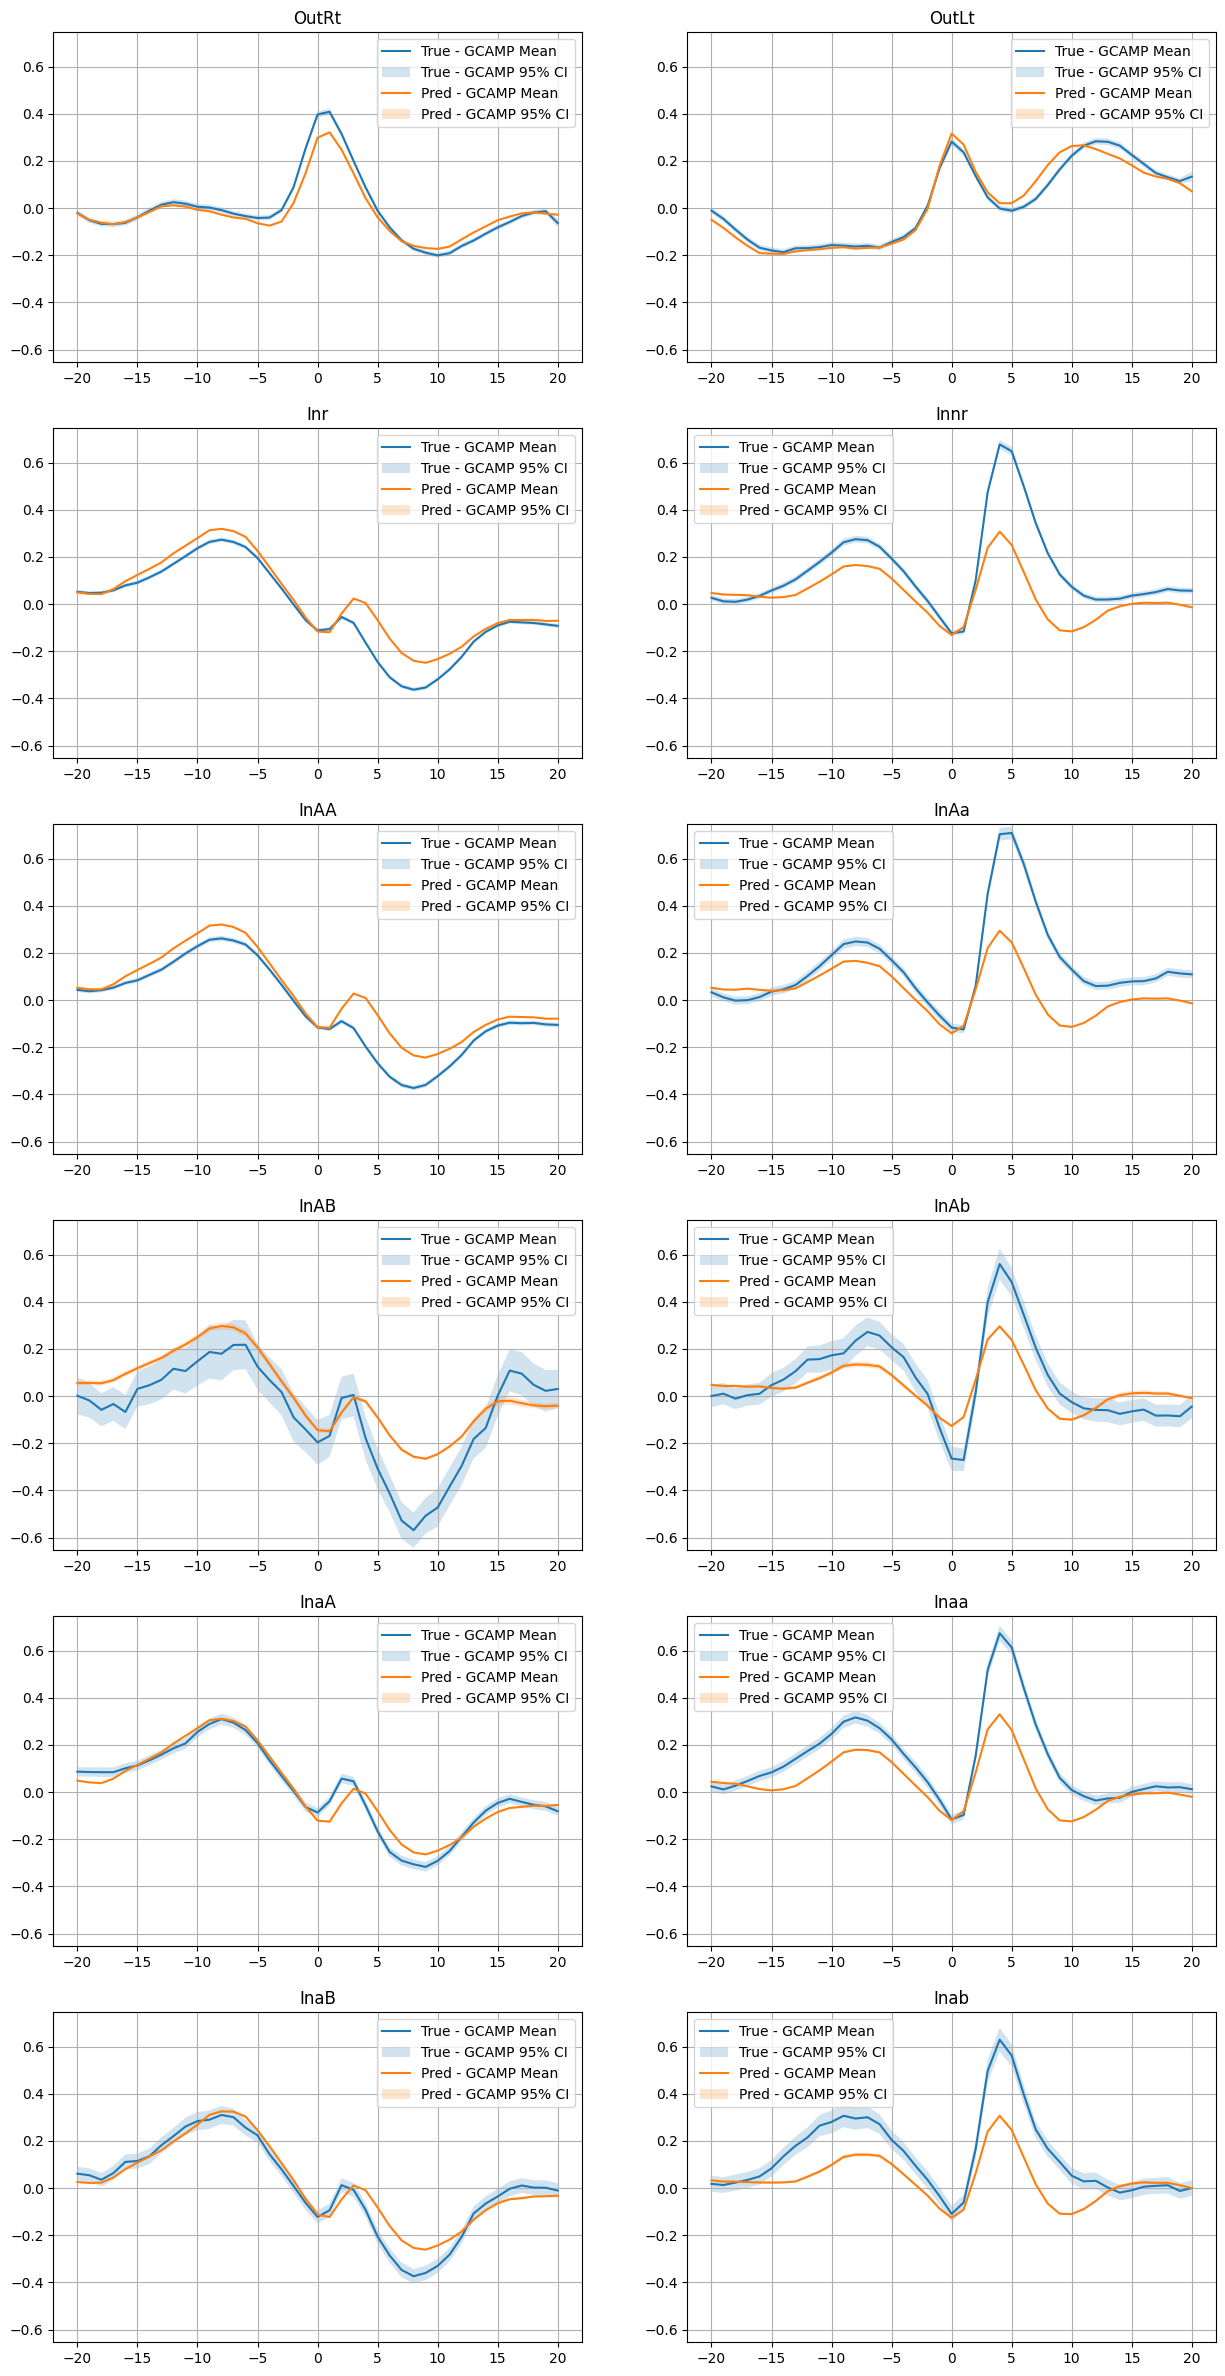

In [144]:
# break

max_cols_len_lst = [max([len(_['X_cols']) for _ in inner_list]) for inner_list in X_y_pairings_lst]
for iXyp, _ in enumerate(X_y_pairings_lst):
    for iXyd, X_y_dct in enumerate(X_y_pairings):
        for igkwargs, glm_kwargs in enumerate(glm_kwarg_lst):
            irun = 0
            
            run_start = time.time()
            Xyp_path = param_set_output_path / Path(f'iXyp_{iXyp}')
            run_path = Xyp_path / Path(f'iXyd_{iXyd}-ikwargs_{igkwargs}') / Path(f'irun_{irun}')
            preds_df = pd.read_csv(run_path / 'preds.csv', low_memory=False, index_col=0)
            preds_df = preds_df[preds_df['has_all_cols']].copy()
            
            preds_df['photometrySideInIndex'] = preds_df['photometrySideInIndexr'] + preds_df['photometrySideInIndexnr']
            
            alignment_cols = ['photometrySideOutIndexRt', 'photometrySideOutIndexLt',
                              
                              'photometrySideInIndexr', 'photometrySideInIndexnr',
                              'photometrySideInIndexAA', 'photometrySideInIndexAa',
                              'photometrySideInIndexAB', 'photometrySideInIndexAb',
                              'photometrySideInIndexaA', 'photometrySideInIndexaa',
                              'photometrySideInIndexaB', 'photometrySideInIndexab',
                             ]
            for alignment_col in alignment_cols:
                
                preds_df['ac_tmp'] = ((~preds_df['dupe'])*1.0)*((preds_df['diffTrialNums']==1.0)*1.0)*preds_df[alignment_col]
                preds_df['entryTime'] = preds_df.groupby(['nTrial_filenum'])['ac_tmp'].transform(np.argmax)

                preds_df['timestep'] = 1
                preds_df['timestep'] = preds_df.groupby(['nTrial_filenum'])['timestep'].cumsum() - 1
                preds_df['timestep'] = preds_df['timestep'] - preds_df['entryTime']
                
                preds_df[f'has_{alignment_col}'] = preds_df.groupby(['nTrial_filenum'])['ac_tmp'].transform(np.sum)
                preds_df[f'ts_{alignment_col}'] = preds_df['timestep']
            
            assert preds_df['holdout'].isna().sum() == 0
            preds_df['holdout'] = preds_df['holdout'].astype(bool)
            
            y_col = X_y_dct['y_col']
            preds_df['resids'] = preds_df[y_col] - preds_df['pred_'+y_col]
            preds_df['residsALL'] = preds_df[y_col] - preds_df['predALL_'+y_col]
            
            filt = (~preds_df['holdout'])&preds_df['wi_trial_keep']
            preds_df_train = preds_df[(~preds_df['holdout'])&preds_df['wi_trial_keep']]
            preds_df_holdout = preds_df[(preds_df['holdout'])&preds_df['wi_trial_keep']]
            
            print(time.time() - run_start)
            
            min_y = +np.inf
            max_y = -np.inf

            fig, axes = plt.subplots(len(alignment_cols)//2,2,figsize=(15,30))
            for iac, alignment_col in enumerate(alignment_cols):
                holdout_agg = preds_df[preds_df[f'has_{alignment_col}'] == 1.0]
                holdout_agg = holdout_agg.groupby([f'ts_{alignment_col}'])[['GCAMP', 'pred_GCAMP']].agg([np.mean, np.std, np.size]).dropna()                
                holdout_agg.columns = ['-'.join(_) for _ in holdout_agg.columns]

                holdout_agg = holdout_agg[holdout_agg.assign(timestep=holdout_agg.index)['timestep'].between(-20,20)]                

                holdout_agg['GCAMP-lb'] = holdout_agg['GCAMP-mean'] - holdout_agg['GCAMP-std']/np.sqrt(holdout_agg['GCAMP-size'])
                holdout_agg['GCAMP-ub'] = holdout_agg['GCAMP-mean'] + holdout_agg['GCAMP-std']/np.sqrt(holdout_agg['GCAMP-size'])

                holdout_agg['pred_GCAMP-lb'] = holdout_agg['pred_GCAMP-mean'] - holdout_agg['pred_GCAMP-std']/np.sqrt(holdout_agg['pred_GCAMP-size'])
                holdout_agg['pred_GCAMP-ub'] = holdout_agg['pred_GCAMP-mean'] + holdout_agg['pred_GCAMP-std']/np.sqrt(holdout_agg['pred_GCAMP-size'])

                min_y = min(min_y, min(holdout_agg['GCAMP-lb'].min()-0.01, holdout_agg['pred_GCAMP-lb'].min()-0.01))
                max_y = max(max_y, max(holdout_agg['GCAMP-ub'].max()+0.01, holdout_agg['pred_GCAMP-ub'].max()+0.01))

                axes[iac//2,iac%2].set_title(alignment_col.replace('photometrySide','').replace('Index',''))
                axes[iac//2,iac%2].plot(holdout_agg['GCAMP-mean'], label='True - GCAMP Mean')
                axes[iac//2,iac%2].fill_between(holdout_agg.index, holdout_agg['GCAMP-lb'], holdout_agg['GCAMP-ub'], alpha=0.2, label='True - GCAMP 95% CI')
                axes[iac//2,iac%2].plot(holdout_agg['pred_GCAMP-mean'], label='Pred - GCAMP Mean')
                axes[iac//2,iac%2].fill_between(holdout_agg.index, holdout_agg['pred_GCAMP-lb'], holdout_agg['pred_GCAMP-ub'], alpha=0.2, label='Pred - GCAMP 95% CI')
                axes[iac//2,iac%2].grid(True)
                axes[iac//2,iac%2].legend()


            i = 0
            for iac in enumerate(alignment_cols):
                axes[i//2,i%2].set_ylim((min_y, max_y))
                i += 1



In [145]:
# tmp = (preds_df.groupby(['nTrial_filenum'])['ac_tmp'].sum())
# tmp[tmp > 1]


# with pd.option_context('display.max_rows',10000,'display.max_columns',10000):
#     display(preds_df[preds_df['nTrial_filenum'] == 1095].iloc[:, list(range(30))].replace(0,np.nan))#+list(range(-20,0))])

In [186]:
def bootstrap_to_lower_upper_bounds(x, func, **kwargs):
    bs = scipy.stats.bootstrap((x,), func, **kwargs)
    return [bs.confidence_interval.low, bs.confidence_interval.high]

  0%|          | 0/12 [00:00<?, ?it/s]

  File "/Users/josh/opt/anaconda3/envs/sglm/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/josh/opt/anaconda3/envs/sglm/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/josh/opt/anaconda3/envs/sglm/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/josh/opt/anaconda3/envs/sglm/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/josh/opt/anaconda3/envs/sglm/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
    self.io_loop.start()
  File "/Users/josh/opt/anaconda3/envs/sglm/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/Users/josh/opt/anaconda3/envs/sglm/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()


,true_lb,true_mean,true_ub,pred_lb,pred_mean,pred_ub
ts_photometrySideInIndexab,,,,,,
-20,-0.017670,1.780992e-02,0.064797,0.027062,0.032596,0.035770
-19,-0.020204,1.300658e-02,0.042786,0.024709,0.027620,0.031367
-18,0.005102,2.333345e-02,0.049474,0.025862,0.027272,0.030114
-17,0.013179,3.449892e-02,0.051642,0.022395,0.025394,0.032134
-16,0.015225,4.915938e-02,0.090815,0.019144,0.023796,0.028450
-15,0.047695,8.381807e-02,0.120548,0.019431,0.023174,0.030563
-14,0.097203,1.348083e-01,0.173563,0.019638,0.024055,0.032718
-13,0.136799,1.792587e-01,0.226982,0.024456,0.027935,0.034622
-12,0.155139,2.148634e-01,0.287270,0.044061,0.048420,0.053907


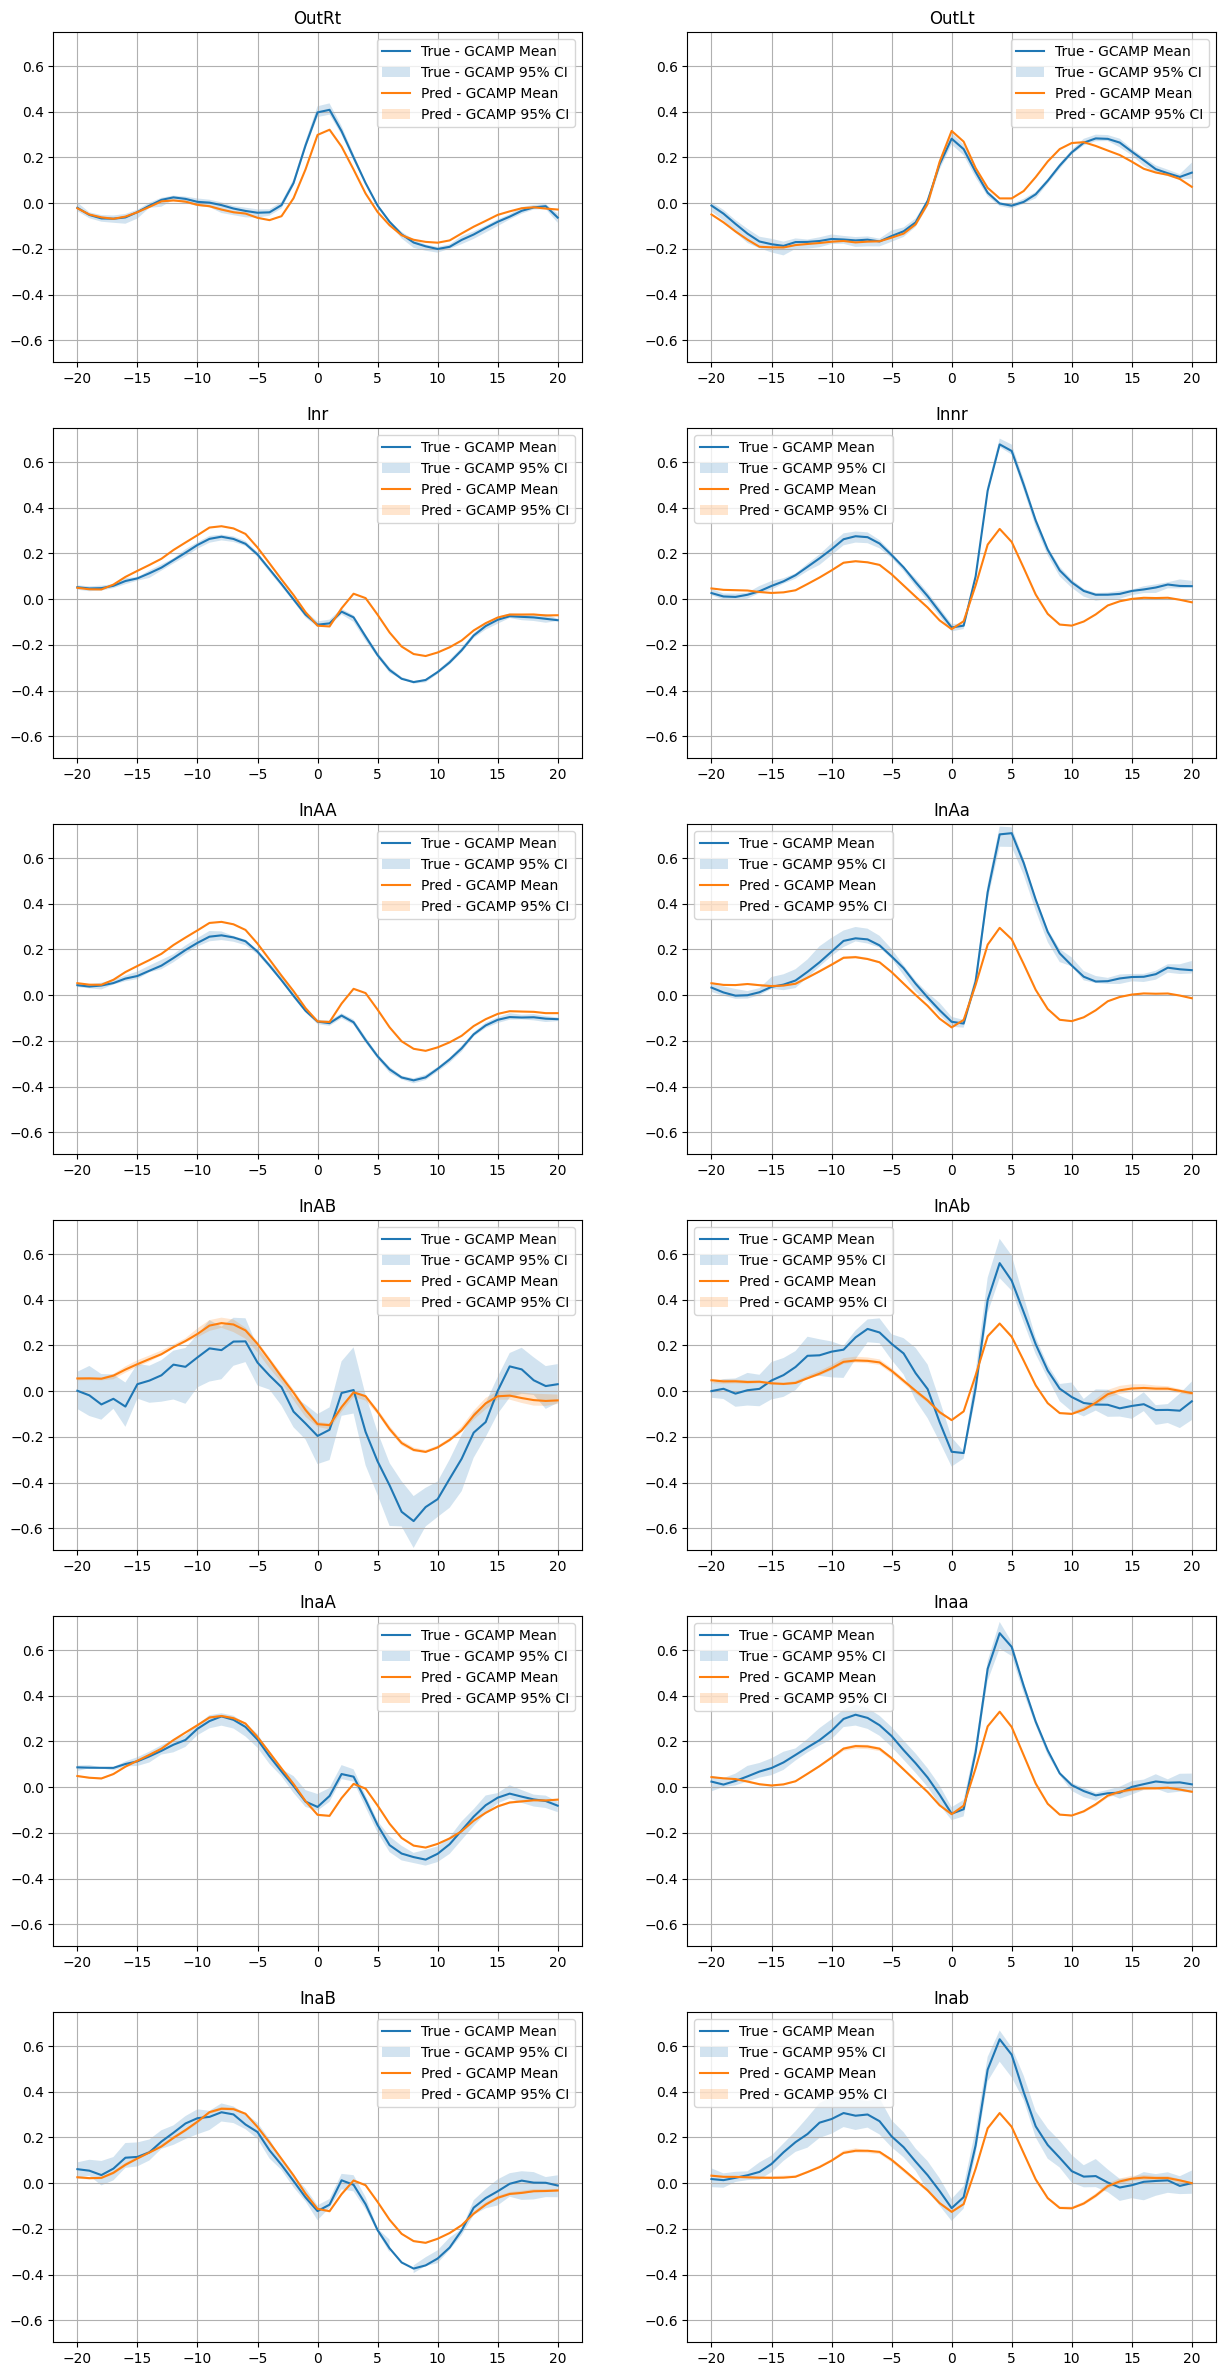

In [211]:
import scipy
from tqdm.notebook import tqdm

seed = np.random.randint(1000000000)
boot_kwargs = dict(n_resamples=10,
               batch=None, vectorized=True, paired=False,
               axis=0, confidence_level=0.95, method='BCa',
               random_state=seed)

min_y = +np.inf
max_y = -np.inf

fig, axes = plt.subplots(len(alignment_cols)//2,2,figsize=(15,30))
for iac, alignment_col in tqdm(enumerate(alignment_cols), total=len(alignment_cols)):
    
    holdout_agg = preds_df[preds_df[f'has_{alignment_col}'] == 1.0]
    holdout_agg = holdout_agg.dropna()
    holdout_agg = holdout_agg[holdout_agg.assign(timestep=holdout_agg[f'ts_{alignment_col}'])['timestep'].between(-20,20)]
#     display(holdout_agg)
    
    true_srs = holdout_agg.groupby(f'ts_{alignment_col}')['GCAMP'].apply(lambda x: np.array(x))
    pred_srs = holdout_agg.groupby(f'ts_{alignment_col}')['pred_GCAMP'].apply(lambda x: np.array(x))
    
    boot_df_setup = pd.DataFrame({
                            'true_mean':true_srs.apply(np.mean),
                            'pred_mean':pred_srs.apply(np.mean),

                            'true_lb_ub':true_srs.apply(lambda x: bootstrap_to_lower_upper_bounds(x, np.mean, **boot_kwargs)),
                            'pred_lb_ub':pred_srs.apply(lambda x: bootstrap_to_lower_upper_bounds(x, np.mean, **boot_kwargs)),
                           })
    
    
    boot_df_setup['true_lb'] = boot_df_setup['true_lb_ub'].apply(lambda x: x[0])
    boot_df_setup['true_ub'] = boot_df_setup['true_lb_ub'].apply(lambda x: x[1])
    boot_df_setup['pred_lb'] = boot_df_setup['pred_lb_ub'].apply(lambda x: x[0])
    boot_df_setup['pred_ub'] = boot_df_setup['pred_lb_ub'].apply(lambda x: x[1])

    boot_df = boot_df_setup[['true_lb', 'true_mean', 'true_ub',
             'pred_lb', 'pred_mean', 'pred_ub',]]
    
    
#     for sft in true_srs.index:
#         sft_data = true_srs.loc[sft]
#         bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
#                                batch=None, vectorized=True, paired=False,
#                                axis=0, confidence_level=0.95, method='BCa',
#                                random_state=seed)
    

#         rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

#         reconstruction_data_list.append(rtup)

#         tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')
    
    
    min_y = min(min_y, min(boot_df['true_lb'].min()-0.01, boot_df['true_lb'].min()-0.01))
    max_y = max(max_y, max(boot_df['true_ub'].max()+0.01, boot_df['true_ub'].max()+0.01))

    axes[iac//2,iac%2].set_title(alignment_col.replace('photometrySide','').replace('Index',''))
    axes[iac//2,iac%2].plot(boot_df['true_mean'], label='True - GCAMP Mean')
    axes[iac//2,iac%2].fill_between(boot_df.index, boot_df['true_lb'], boot_df['true_ub'], alpha=0.2, label='True - GCAMP 95% CI')
    axes[iac//2,iac%2].plot(boot_df['pred_mean'], label='Pred - GCAMP Mean')
    axes[iac//2,iac%2].fill_between(boot_df.index, boot_df['pred_lb'], boot_df['pred_ub'], alpha=0.2, label='Pred - GCAMP 95% CI')
    axes[iac//2,iac%2].grid(True)
    axes[iac//2,iac%2].legend()

i = 0
for iac in enumerate(alignment_cols):
    axes[i//2,i%2].set_ylim((min_y, max_y))
    i += 1

boot_df
    

In [208]:
boot_df

,true_lb,true_mean,true_ub,pred_lb,pred_mean,pred_ub
ts_photometrySideInIndexab,,,,,,
-20,-0.006645,1.780992e-02,0.049108,0.027781,0.032596,0.039697
-19,-0.012604,1.300658e-02,0.038504,0.022251,0.027620,0.033045
-18,-0.012075,2.333345e-02,0.048367,0.020103,0.027272,0.031310
-17,0.005095,3.449892e-02,0.060136,0.014909,0.025394,0.028338
-16,0.038707,4.915938e-02,0.072012,0.013992,0.023796,0.027729
-15,0.044749,8.381807e-02,0.124067,0.015899,0.023174,0.027393
-14,0.076404,1.348083e-01,0.193189,0.017513,0.024055,0.029788
-13,0.103231,1.792587e-01,0.211062,0.023725,0.027935,0.034820
-12,0.132019,2.148634e-01,0.270346,0.040036,0.048420,0.055701


In [ ]:


# min_y = +np.inf
# max_y = -np.inf

# fig, axes = plt.subplots(len(alignment_cols)//2,2,figsize=(15,30))
# for iac, alignment_col in enumerate(alignment_cols):
#     holdout_agg = preds_df[preds_df[f'has_{alignment_col}'] == 1.0]
#     holdout_agg = holdout_agg.groupby([f'ts_{alignment_col}'])[['true', 'pred']].agg([np.mean, np.std, np.size]).dropna()
#     holdout_agg.columns = ['-'.join(_) for _ in holdout_agg.columns]

#     holdout_agg = holdout_agg[holdout_agg.assign(timestep=holdout_agg.index)['timestep'].between(-20,20)]                

#     min_y = min(min_y, min(holdout_agg['true_lb'].min()-0.01, holdout_agg['true_lb'].min()-0.01))
#     max_y = max(max_y, max(holdout_agg['true_ub'].max()+0.01, holdout_agg['true_ub'].max()+0.01))

#     axes[iac//2,iac%2].set_title(alignment_col.replace('photometrySide','').replace('Index',''))
#     axes[iac//2,iac%2].plot(holdout_agg['true_mean'], label='True - GCAMP Mean')
#     axes[iac//2,iac%2].fill_between(holdout_agg.index, holdout_agg['true_lb'], holdout_agg['true_ub'], alpha=0.2, label='True - GCAMP 95% CI')
#     axes[iac//2,iac%2].plot(holdout_agg['true_mean'], label='Pred - GCAMP Mean')
#     axes[iac//2,iac%2].fill_between(holdout_agg.index, holdout_agg['true_lb'], holdout_agg['true_ub'], alpha=0.2, label='Pred - GCAMP 95% CI')
#     axes[iac//2,iac%2].grid(True)
#     axes[iac//2,iac%2].legend()




In [146]:
# # stack all true values together--(along delta)
# # for delta long the rows... drop any nan values
# # bootstrap along the row


# seed = np.random.randint(1000000000)
# row = tmp_rdc.loc[delta].dropna().values
# bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
#                            batch=None, vectorized=True, paired=False,
#                            axis=0, confidence_level=0.95, method='BCa',
#                            random_state=seed)

# mn_val = row.mean()
# rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

# reconstruction_data_list.append(rtup)

# tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')


# seed = np.random.randint(1000000000)
# row = tmp_rdc.loc[delta].dropna().values
# bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
#                            batch=None, vectorized=True, paired=False,
#                            axis=0, confidence_level=0.95, method='BCa',
#                            random_state=seed)

# mn_val = row.mean()
# rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

# reconstruction_data_list.append(rtup)

# tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')


In [62]:
# preds_df_holdout.groupby(['nTrial_filenum', 'timestep'])[['GCAMP', 'pred_GCAMP']].agg([np.mean, np.std])

In [205]:



# [['GCAMP', 'pred_GCAMP']]